# Lateness

- berücksichtigt auch eine negative Abweichung, also wenn ein Job früher fertiggestellt wurde als geplant.

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**  
- $L_j = 0$: Job ist **pünktlich**  
- $L_j < 0$: Job ist **zu früh** fertig

In [4]:
max_time = 60 * 15 # 15min

In [5]:
import time

import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
import numpy as np
import pandas as pd
from ortools.sat.python import cp_model
pd.set_option('display.max_rows', 15)

In [7]:
import utils.presenter as show
import utils.checker as check

import utils.rolling_planning.init_jobs_times as rp_init
import utils.schedule_deadline as deadline_gen

In [8]:
import utils.scheduling_solver as ssv

In [9]:
df_instance= pd.read_csv("data/00_instance.csv")

df_jssp, df_arrivals = rp_init.init_jobs_with_arrivals(df_instance, 1, u_b_mmax= 0.98)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
185,Job_018,5,M9,76
186,Job_018,6,M5,47
187,Job_018,7,M3,52
188,Job_018,8,M4,90


### a) Initialisierung der Deadlines

In [11]:
df_times = deadline_gen.get_times_df(df_jssp, df_arrivals, ssv.schedule_fcfs_with_arrivals, target_service=1)
df_times

,Job,Arrival,Deadline
0,Job_000,0.00,1063
1,Job_001,80.87,1453
2,Job_002,140.32,1668
3,Job_003,191.00,1953
4,Job_004,226.49,1284
...,...,...,...
14,Job_014,1093.73,2855
15,Job_015,1099.60,2157
16,Job_016,1100.92,2629
17,Job_017,1216.01,2279


In [12]:
# Rundung für CP 
df_times["Arrival"] = np.floor(df_times["Arrival"]).astype(int)
df_times["Deadline"] = np.ceil(df_times["Deadline"]).astype(int)
df_times

,Job,Arrival,Deadline
0,Job_000,0,1063
1,Job_001,80,1453
2,Job_002,140,1668
3,Job_003,191,1953
4,Job_004,226,1284
...,...,...,...
14,Job_014,1093,2855
15,Job_015,1099,2157
16,Job_016,1100,2629
17,Job_017,1216,2279


### b) Bestimmung der "Ready Time"

In [14]:
df_times['Ready Time'] = ((df_times['Arrival'] // 1440) + 1) * 1440
df_times

,Job,Arrival,Deadline,Ready Time
0,Job_000,0,1063,1440
1,Job_001,80,1453,1440
2,Job_002,140,1668,1440
3,Job_003,191,1953,1440
4,Job_004,226,1284,1440
...,...,...,...,...
14,Job_014,1093,2855,1440
15,Job_015,1099,2157,1440
16,Job_016,1100,2629,1440
17,Job_017,1216,2279,1440


In [16]:
processing_time = df_jssp.groupby('Job')['Processing Time'].sum()
df_times = pd.merge(df_times, processing_time, on='Job')
df_times 

,Job,Arrival,Deadline,Ready Time,Processing Time
0,Job_000,0,1063,1440,395
1,Job_001,80,1453,1440,510
2,Job_002,140,1668,1440,568
3,Job_003,191,1953,1440,655
4,Job_004,226,1284,1440,393
...,...,...,...,...,...
14,Job_014,1093,2855,1440,655
15,Job_015,1099,2157,1440,393
16,Job_016,1100,2629,1440,568
17,Job_017,1216,2279,1440,395


### c) Bestimmung des Slacks
> mit "Ready Time" statt Arrival 

In [17]:
df_times['Slack'] = df_times['Deadline'] - (df_times['Ready Time'] + df_times['Processing Time'])
df_times 

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
0,Job_000,0,1063,1440,395,-772
1,Job_001,80,1453,1440,510,-497
2,Job_002,140,1668,1440,568,-340
3,Job_003,191,1953,1440,655,-142
4,Job_004,226,1284,1440,393,-549
...,...,...,...,...,...,...
14,Job_014,1093,2855,1440,655,760
15,Job_015,1099,2157,1440,393,324
16,Job_016,1100,2629,1440,568,621
17,Job_017,1216,2279,1440,395,444


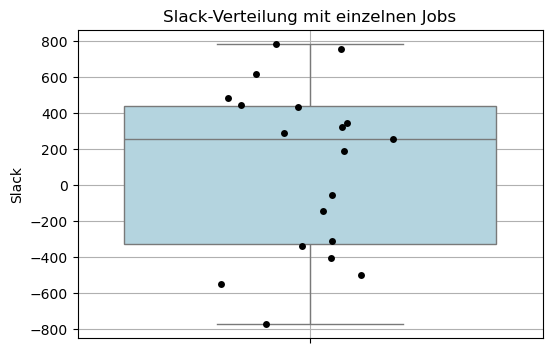

In [18]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=df_times['Slack'], color='lightblue')
sns.stripplot(y=df_times['Slack'], color='black', size=5, jitter=0.2)
plt.title('Slack-Verteilung mit einzelnen Jobs')
plt.ylabel('Slack')
plt.grid(True)
plt.show()


In [19]:
q25 = df_times['Slack'].quantile(0.25)
print("25%-Quantil (Q1) von Slack:", q25)


25%-Quantil (Q1) von Slack: -324.0


### d) Anpassung der Deadlines
> Addition des absoluten minimalen "negativen Slacks"

In [21]:
df_times['Slack'].min()

-772

In [22]:
abs(df_times['Slack'].min())

772

In [23]:
min_slack = df_times['Slack'].min()

if min_slack < 0:
    df_times["Deadline"] = df_times["Deadline"] + abs(min_slack)
df_times

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
0,Job_000,0,1835,1440,395,-772
1,Job_001,80,2225,1440,510,-497
2,Job_002,140,2440,1440,568,-340
3,Job_003,191,2725,1440,655,-142
4,Job_004,226,2056,1440,393,-549
...,...,...,...,...,...,...
14,Job_014,1093,3627,1440,655,760
15,Job_015,1099,2929,1440,393,324
16,Job_016,1100,3401,1440,568,621
17,Job_017,1216,3051,1440,395,444


### e) erneute Bestimmung des Slacks

In [25]:
df_times['Slack'] = df_times['Deadline'] - (df_times['Ready Time'] + df_times['Processing Time'])
df_times 

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
0,Job_000,0,1835,1440,395,0
1,Job_001,80,2225,1440,510,275
2,Job_002,140,2440,1440,568,432
3,Job_003,191,2725,1440,655,630
4,Job_004,226,2056,1440,393,223
...,...,...,...,...,...,...
14,Job_014,1093,3627,1440,655,1532
15,Job_015,1099,2929,1440,393,1096
16,Job_016,1100,3401,1440,568,1393
17,Job_017,1216,3051,1440,395,1216


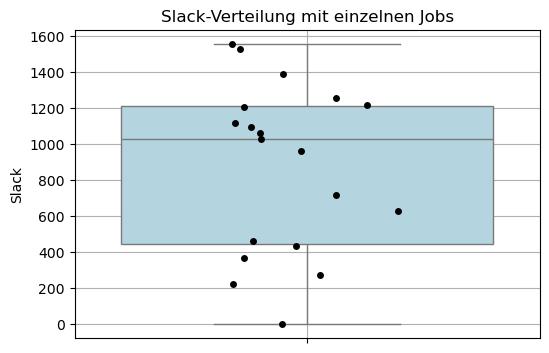

In [26]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=df_times['Slack'], color='lightblue')
sns.stripplot(y=df_times['Slack'], color='black', size=5, jitter=0.2)
plt.title('Slack-Verteilung mit einzelnen Jobs')
plt.ylabel('Slack')
plt.grid(True)
plt.show()


## A) Summe der absoluten Lateness je Job (letze Operation)

$$
\min \sum_{j \in J} \left| C_j - d_j \right|
$$

- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Endzeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\left| C_j - d_j \right|$: absolute Abweichung zur Deadline

**Erklärung:**  
Diese Zielfunktion minimiert die **Summe aller Abweichungen zur Deadline**, unabhängig davon, ob ein Job zu früh oder zu spät fertig wird.  
Sie fördert eine **gleichmäßige, zentrierte Fertigstellung** aller Jobs um ihre Soll-Zeitpunkte (Deadlines).



In [29]:
from ortools.sat.python import cp_model
import pandas as pd

def solve_cp_jssp_sum_absolute_lateness(
    df_jssp: pd.DataFrame,
    df_arrivals_deadlines: pd.DataFrame,
    schedule_start: float = 0.0,
    sort_ascending: bool = False,
    msg: bool = False,
    timeLimit: int = 3600,
    gapRel: float = 0.0
) -> pd.DataFrame:
    from ortools.sat.python import cp_model
    import pandas as pd
    import math

    model = cp_model.CpModel()

    # Sortiere nach Deadline, falls gewünscht
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # Gruppiere Operationen je Job
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    horizon = int(df_jssp["Processing Time"].sum() + max(deadline.values()))

    # Variablen definieren
    starts, ends, intervals = {}, {}, {}
    abs_lateness_vars = []

    for j, job in enumerate(jobs):
        seq = all_ops[j]
        for o, (op_id, m, d) in enumerate(seq):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

    # Lateness-Berechnung und Nebenbedingungen pro Job
    for j, job in enumerate(jobs):
        last_op = len(all_ops[j]) - 1
        job_end = ends[(j, last_op)]

        # Lateness kann positiv (zu spät) oder negativ (zu früh) sein
        lateness = model.NewIntVar(-horizon, horizon, f"lateness_{j}")
        abs_lateness = model.NewIntVar(0, horizon, f"abs_lateness_{j}")
        model.Add(lateness == job_end - deadline[job])
        model.AddAbsEquality(abs_lateness, lateness)
        abs_lateness_vars.append(abs_lateness)

        # Startzeitbedingung (max von Arrival und schedule_start)
        model.Add(starts[(j, 0)] >= max(arrival[job], int(math.ceil(schedule_start))))

        # Technologische Reihenfolge
        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])

    # Maschinenrestriktionen
    for m in machines:
        machine_intervals = [intervals[(j, o)][0] for (j, o), (interval, mach) in intervals.items() if mach == m]
        model.AddNoOverlap(machine_intervals)

    # Zielfunktion
    model.Minimize(sum(abs_lateness_vars))

    # Solver starten
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = msg
    solver.parameters.max_time_in_seconds = timeLimit
    solver.parameters.relative_gap_limit = gapRel

    status = solver.Solve(model)

    # Lösung extrahieren (nur bei OPTIMAL oder FEASIBLE)
    records = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        for j, job in enumerate(jobs):
            for o, (op_id, m, d) in enumerate(all_ops[j]):
                st = solver.Value(starts[(j, o)])
                ed = st + d
                lateness = ed - deadline[job]
                records.append({
                    "Job": job,
                    "Operation": op_id,
                    "Arrival": arrival[job],
                    "Deadline": deadline[job],
                    "Machine": m,
                    "Start": st,
                    "Processing Time": d,
                    "End": ed,
                    "Lateness": lateness,
                    "Absolute Lateness": abs(lateness)
                })

        df_schedule = pd.DataFrame.from_records(records).sort_values(["Start", "Job", "Operation"]).reset_index(drop=True)
    else:
        print(f"\nSolver-Status         : {solver.StatusName(status)}")
        print("No feasible solution found!")
        df_schedule = pd.DataFrame()

    # Logging
    print(f"\nSolver-Status         : {solver.StatusName(status)}")
    print(f"Summe Absolute Lateness : {solver.ObjectiveValue()}")
    print(f"Best Objective Bound    : {solver.BestObjectiveBound()}")
    print(f"Laufzeit                : {solver.WallTime():.2f} Sekunden")

    return df_schedule



In [30]:
starting_time = time.time()

# Scheduling
df_plan_sum_l = solve_cp_jssp_sum_absolute_lateness(df_jssp, df_times, msg=False, 
                                                    schedule_start = 1440,
                                                    timeLimit=max_time)

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan_sum_l


Solver-Status         : OPTIMAL
Summe Absolute Lateness : 29.0
Best Objective Bound    : 29.0
Laufzeit                : 0.08 Sekunden

Scheduling-Dauer: 0 Minuten und 0.11 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Absolute Lateness
0,Job_000,0,0,1835,M0,1440,29,1469,-366,366
1,Job_004,0,226,2056,M2,1440,14,1454,-602,602
2,Job_005,0,293,2400,M2,1454,84,1538,-862,862
3,Job_000,1,0,1835,M1,1469,78,1547,-288,288
4,Job_001,0,80,2225,M0,1469,43,1512,-713,713
...,...,...,...,...,...,...,...,...,...,...
185,Job_014,7,1093,3627,M3,3280,98,3378,-249,249
186,Job_016,9,1100,3401,M4,3368,33,3401,0,0
187,Job_014,8,1093,3627,M9,3378,22,3400,-227,227
188,Job_018,9,1312,3537,M7,3492,45,3537,0,0


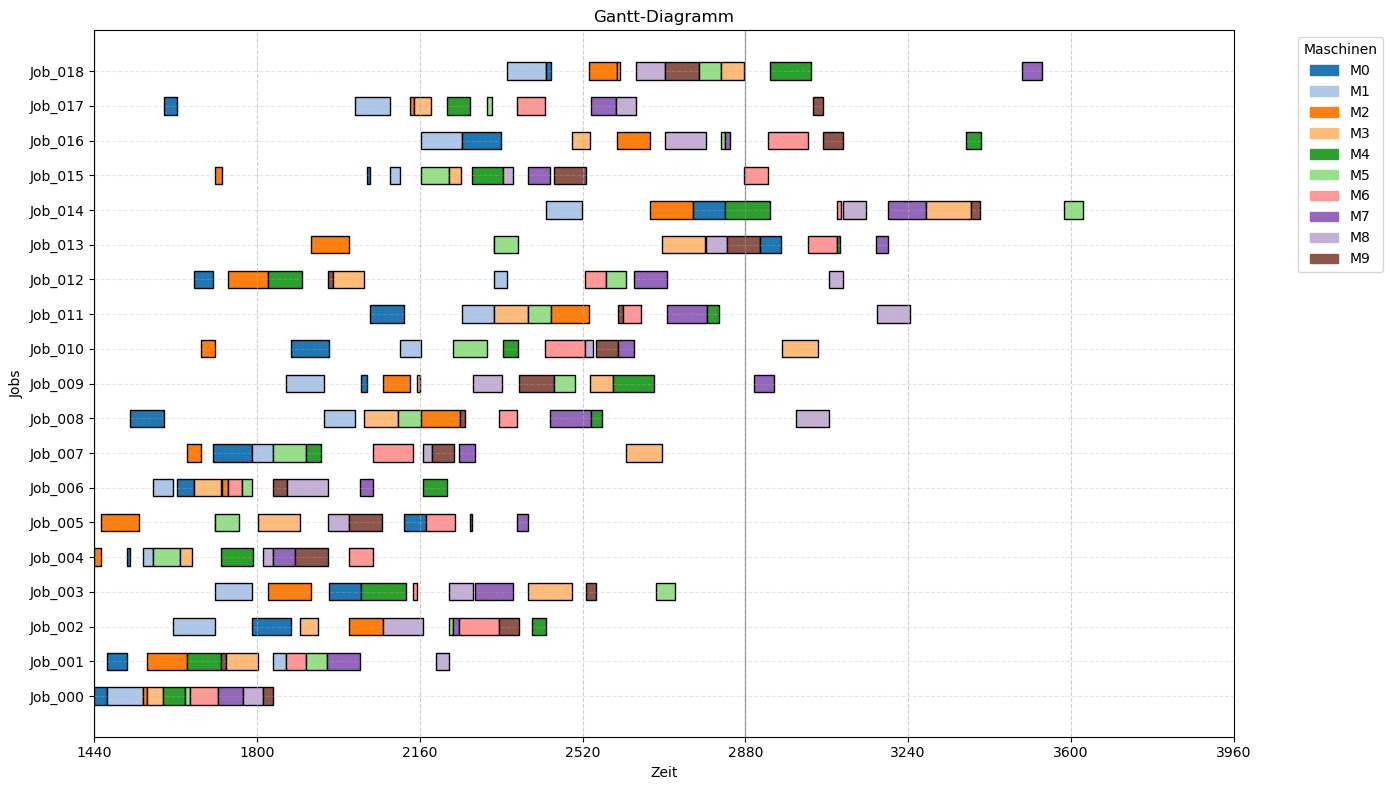

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [31]:
df_plan = df_plan_sum_l

show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

In [32]:
last_ops = df_plan_sum_l.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
show.count_column_grouped(last_ops, 'Lateness', min_val = 0, max_val=60, steps=10)

label
<-60          0
-60 - -50     0
-50 - -40     0
-40 - -30     0
-30 - -20     0
-20 - -10     0
-10 - 0       0
0            18
0 - 10        0
10 - 20       0
20 - 30       1
30 - 40       0
40 - 50       0
50 - 60       0
>60           0
Name: count, dtype: int32

## B) Summe der Lateness minimieren (gewichtet Tardiness und Earliness)

### Zielfunktion

$$
\min \sum_{j \in J} \left( w_t \cdot \max(C_j - d_j,\ 0) + w_e \cdot \max(d_j - C_j,\ 0) \right)
$$


- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Endzeit (Completion Time) des letzten Arbeitsschritts von Job $j$  
- $d_j$: Deadline (Soll-Endzeitpunkt) von Job $j$  
- $w_t$: Gewichtung der **Tardiness** (Verspätung)  
- $w_e$: Gewichtung der **Earliness** (Frühfertigkeit)  
- $\max(C_j - d_j,\ 0)$: positive Verspätung  
- $\max(d_j - C_j,\ 0)$: positive Frühfertigkeit  

### Erklärung

Diese Zielfunktion minimiert die gewichtete Summe aus **Tardiness** (Verspätung) und **Earliness** (Frühfertigkeit) aller Jobs.  
Dabei wird jede Abweichung zur Deadline einzeln bewertet:

- **Tardiness** wird mit $w_t$ gewichtet und tritt auf, wenn ein Job **nach** seiner Deadline fertig wird.
- **Earliness** wird mit $w_e$ gewichtet und tritt auf, wenn ein Job **vor** seiner Deadline fertig wird.

Durch die Wahl von $w_t \gg w_e$ kannst du **Verspätungen deutlich stärker bestrafen** als Frühfertigkeiten.



In [35]:
from ortools.sat.python import cp_model
import pandas as pd

def solve_cp_jssp_lateness_by_tardiness_and_earliness(
    df_jssp: pd.DataFrame,
    df_arrivals_deadlines: pd.DataFrame,
    w_t: int = 5,
    w_e: int = 1,
    schedule_start: float = 0.0,
    sort_ascending: bool = False,
    msg: bool = False,
    timeLimit: int = 3600,
    gapRel: float = 0.0
) -> pd.DataFrame:
    """
    Solves a Job-Shop Scheduling Problem (JSSP) using Constraint Programming with:
    - weighted tardiness (late completion),
    - weighted earliness (early completion),
    - optional global scheduling start time (schedule_start).

    Parameters:
        df_jssp: DataFrame with job-shop structure: ['Job','Operation','Machine','Processing Time']
        df_arrivals_deadlines: DataFrame with ['Job','Arrival','Deadline'] for each job
        w_t: Weight for tardiness penalty (default: 5)
        w_e: Weight for earliness penalty (default: 1)
        schedule_start: Earliest time from which operations may be scheduled (default: 0.0)
        sort_ascending: If True, jobs are sorted by deadline ascending (default: False)
        msg: Verbose solver output (default: False)
        timeLimit: Maximum solver time in seconds (default: 3600)
        gapRel: Acceptable relative gap for feasible solutions (default: 0.0)

    Returns:
        df_schedule: DataFrame with planned operations, start/end times, and lateness metrics.
    """
    from ortools.sat.python import cp_model
    import pandas as pd
    import math

    model = cp_model.CpModel()

    # Gewichte als ganze Zahlen für CP-Modell
    w_t = int(w_t)
    w_e = int(w_e)

    # === Vorbereitung: Jobliste, Ankunft, Deadlines ===
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # === Operationen je Job strukturieren und Maschinen erfassen ===
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    # === Grobe obere Schranke für Planungshorizont ===
    horizon = int(df_jssp["Processing Time"].sum() + max(deadline.values()))

    # === Zeitvariablen und Intervalle anlegen ===
    starts, ends, intervals = {}, {}, {}
    weighted_terms = []

    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

    # === Zielgrößen pro Job berechnen ===
    for j, job in enumerate(jobs):
        last_op_index = len(all_ops[j]) - 1
        job_end = ends[(j, last_op_index)]

        # Lateness = tatsächliches Ende - Deadline
        lateness = model.NewIntVar(-horizon, horizon, f"lateness_{j}")
        model.Add(lateness == job_end - deadline[job])

        # Tardiness = max(0, Lateness)
        tardiness = model.NewIntVar(0, horizon, f"tardiness_{j}")
        model.AddMaxEquality(tardiness, [lateness, 0])
        term_tardiness = model.NewIntVar(0, horizon * w_t, f"term_tardiness_{j}")
        model.Add(term_tardiness == w_t * tardiness)
        weighted_terms.append(term_tardiness)

        # Earliness = max(0, -Lateness)
        earliness = model.NewIntVar(0, horizon, f"earliness_{j}")
        model.AddMaxEquality(earliness, [-lateness, 0])
        term_earliness = model.NewIntVar(0, horizon * w_e, f"term_earliness_{j}")
        model.Add(term_earliness == w_e * earliness)
        weighted_terms.append(term_earliness)

        # Startbedingung für erste Operation: max(Arrival, schedule_start)
        # Verhindert Einplanung vor Beginn des neuen Planungshorizonts
        model.Add(starts[(j, 0)] >= max(arrival[job], int(math.ceil(schedule_start))))

        # Technologische Reihenfolge: O_i+1 nach O_i
        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])

    # === Maschinenrestriktionen: keine Überlappung pro Maschine ===
    for m in machines:
        machine_intervals = [intervals[(j, o)][0] for (j, o), (iv, mach) in intervals.items() if mach == m]
        model.AddNoOverlap(machine_intervals)

    # === Zielfunktion: gewichtete Summe aus Tardiness und Earliness minimieren ===
    model.Minimize(sum(weighted_terms))

    # === Solver konfigurieren ===
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = msg
    solver.parameters.relative_gap_limit = gapRel
    solver.parameters.max_time_in_seconds = timeLimit
    status = solver.Solve(model)

    # === Ergebnis extrahieren ===
    records = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        for j, job in enumerate(jobs):
            for o, (op_id, m, d) in enumerate(all_ops[j]):
                st = solver.Value(starts[(j, o)])
                ed = st + d
                lateness_val = ed - deadline[job]
                records.append({
                    "Job": job,
                    "Operation": op_id,
                    "Arrival": arrival[job],
                    "Deadline": deadline[job],
                    "Machine": m,
                    "Start": st,
                    "Processing Time": d,
                    "End": ed,
                    "Lateness": lateness_val,
                    "Tardiness": max(0, lateness_val),
                    "Earliness": max(0, -lateness_val)
                })

        df_schedule = pd.DataFrame.from_records(records).sort_values(["Start", "Job", "Operation"]).reset_index(drop=True)
    else:
        print(f"\nSolver-Status         : {solver.StatusName(status)}")
        print("No feasible solution found!")
        df_schedule = pd.DataFrame()

    # === Zusammenfassung der Lösung ===
    print(f"\nSolver-Status         : {solver.StatusName(status)}")
    print(f"Objective Value       : {solver.ObjectiveValue():.2f}")
    print(f"Best Objective Bound  : {solver.BestObjectiveBound():.2f}")
    print(f"Laufzeit              : {solver.WallTime():.2f} Sekunden")

    return df_schedule


In [36]:
import time

starting_time = time.time()

# Aufruf der vereinfachten Zielfunktion: Tardiness und Earliness für die letzte Operation
df_plan = solve_cp_jssp_lateness_by_tardiness_and_earliness(
    df_jssp, df_times,
    w_t=5,      # Gewicht für Tardiness (Verspätung)
    schedule_start = 1440,
    msg=False,
    timeLimit=60,
    gapRel=0.01
)

ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")



Solver-Status         : OPTIMAL
Objective Value       : 29.00
Best Objective Bound  : 29.00
Laufzeit              : 0.70 Sekunden

Scheduling-Dauer: 0 Minuten und 0.78 Sekunden.


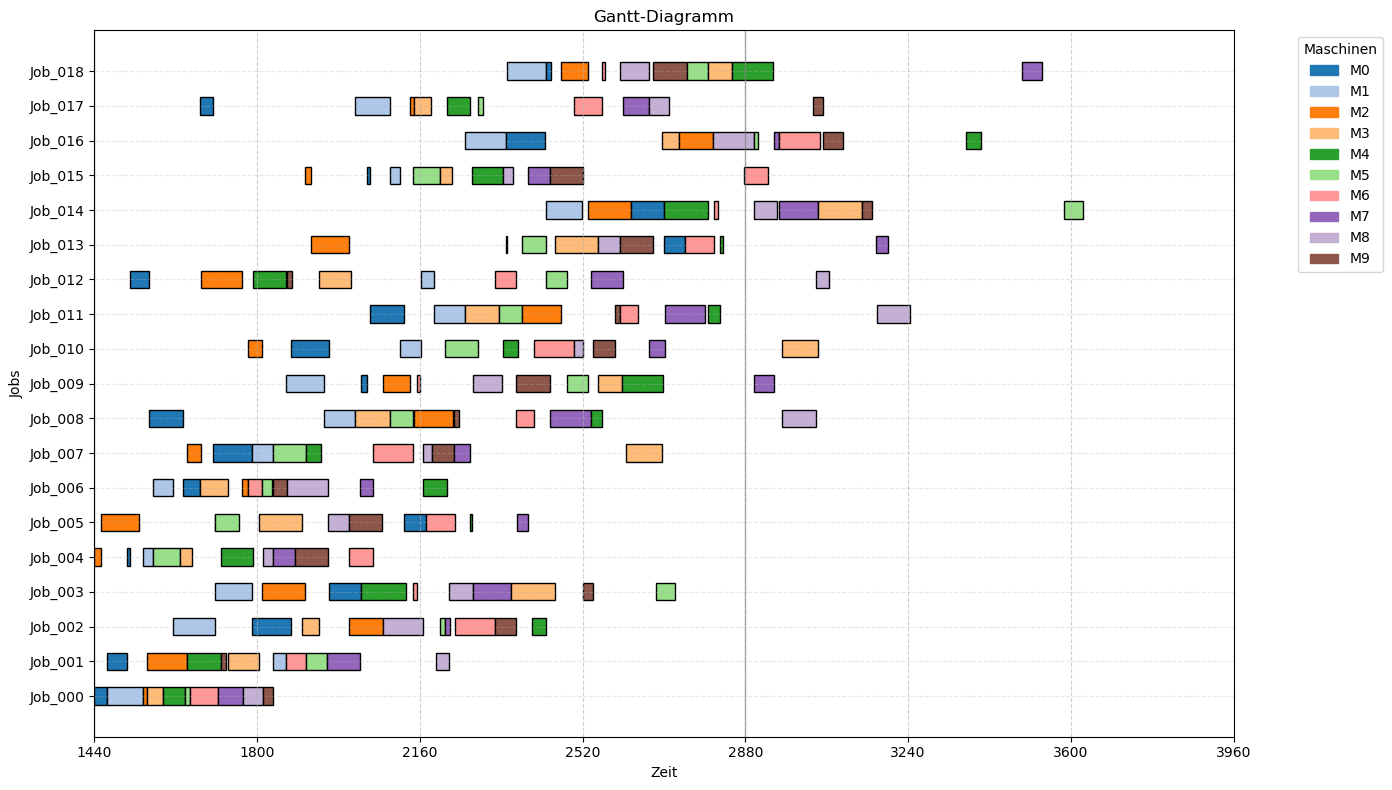

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [37]:
show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

In [38]:
last_ops = df_plan.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
show.count_column_grouped(last_ops, "Lateness", max_val = 60, steps= 30)

label
<-60          0
-60 - -30     0
-30 - 0       1
0            18
0 - 30        0
30 - 60       0
>60           0
Name: count, dtype: int32